In [36]:
# import dependencies
import math
import json
import pymongo
import requests
import numpy as np
import pandas as pd
from config import api_key
from pymongo import MongoClient
from datetime import date, datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')

In [37]:
# Pull NASDAQ 100 information from nasdaq_constituent API 
# Set url
url = "https://financialmodelingprep.com/api/v3/nasdaq_constituent?apikey="+ api_key

# Get response using requests.request("GET", url).json()
response = requests.request("GET", url).json()

# Display reponse in order to use response
response

[{'symbol': 'DOCU',
  'name': 'DocuSign Inc',
  'sector': 'Technology',
  'subSector': 'Technology',
  'headQuarter': 'San Francisco, CALIFORNIA',
  'dateFirstAdded': '2020-06-22',
  'cik': '0001261333',
  'founded': '2018-04-27'},
 {'symbol': 'ZM',
  'name': 'Zoom Video Communications Inc',
  'sector': 'Communication Services',
  'subSector': 'Communication Services',
  'headQuarter': 'San Jose, CALIFORNIA',
  'dateFirstAdded': '2020-04-30',
  'cik': '0001585521',
  'founded': '2019-04-18'},
 {'symbol': 'DXCM',
  'name': 'DexCom Inc',
  'sector': 'Healthcare',
  'subSector': 'Healthcare',
  'headQuarter': 'San Diego, CALIFORNIA',
  'dateFirstAdded': '2020-04-20',
  'cik': '0001093557',
  'founded': '2005-04-14'},
 {'symbol': 'SPLK',
  'name': 'Splunk Inc',
  'sector': 'Technology',
  'subSector': 'Technology',
  'headQuarter': 'San Francisco, CALIFORNIA',
  'dateFirstAdded': '2019-12-23',
  'cik': '0001353283',
  'founded': '2012-04-19'},
 {'symbol': 'SGEN',
  'name': 'Seattle Genetic

In [38]:
stock_symbols = []
for r in response:
    collect_symbols = r['symbol']
    stock_symbols.append(collect_symbols)
    
#print(stock_symbols[0])

In [39]:
# Create connection to mongoDB
client = MongoClient('mongodb://localhost:27017')
# Connect to stock_df database in mongoDB
db = client.testing_stock ###################

In [40]:
# Create variable for new_input
new_input = "ZM"

In [41]:
# Retrive data
one_stock = db.dummy_test.find_one({'symbol': new_input}) ########################3

# Isolate symbol and historical data
symbol = one_stock['symbol']
historical_data = one_stock['historical']

stock_date = []
close = []

for h in historical_data:
    
    collect_dates = h['date']
    stock_date.append(collect_dates)
    
    collect_close = h['close']
    close.append(collect_close)

In [42]:
# Create date variables for API request
# Set variable for current date 
current_date = date.today()
print(current_date)
# Retrive last date stored in MongoDB
last_date = max(stock_date)
print(last_date)

2021-03-04
2021-03-03


In [43]:
#Create new_start_date to be a day after the last date
date = datetime.strptime(last_date, '%Y-%m-%d') 
print(date)
modified_date = date + timedelta(days=1)
print(modified_date)
new_start_date = datetime.strftime(modified_date, '%Y-%m-%d')
print(new_start_date)

2021-03-03 00:00:00
2021-03-04 00:00:00
2021-03-04


In [44]:
print(new_start_date)

2021-03-04


In [46]:
# Set new url to update data
url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{new_input}?from={new_start_date}&to={current_date}&apikey={api_key}"
url


'https://financialmodelingprep.com/api/v3/historical-price-full/ZM?from=2021-03-04&to=2021-03-04&apikey=96b47c522f00a29fe1b11cfd2b0b02d9'

In [12]:
# conditional statement to determine if an update query is needed
# based on if last_data in MongDb < current_date being requested
if str(last_date) < str(current_date):
    print(f"Last date in MongoDB is: {last_date}")
    # if so send new request fro url with new start and end date
    new_results = requests.request("GET", url).json()
    #print(new_results)
    
    if new_results == False:
        print("not null")
        # Isolate historical data
        historical_update = new_results['historical']
        #for loop through historacal_update to retrive updated data
        for h in historical_update:
            # Retrieve new date and close data
            date_update = h['date']
            close_update = h['close']
            #print(f"Date update {date_update}")
            #print(f"Close update {close_update}")
            # Send update to MongoDb and push tp historical list
            #db.stock_data.update_one({'symbol': new_input}, {'$push': {'historical': {'date': date_update, 'close': close_update}}})
            #print("Update complete")   
    else:
        print("Data up to date")

Last date in MongoDB is: 2021-03-03
Data up to date


In [13]:
# Retrive data
one_stock = db.dummy_test.find_one({'symbol': new_input}) ########################3

# Isolate symbol and historical data
symbol = one_stock['symbol']
historical_data = one_stock['historical']

stock_date = []
close = []

for h in historical_data:
    
    collect_dates = h['date']
    stock_date.append(collect_dates)
    
    collect_close = h['close']
    close.append(collect_close)

In [14]:
df = pd.DataFrame({'Date': stock_date,
                  'close': close})
df.head()

,Date,close
0,2019-04-18,62.0
1,2019-04-22,65.7
2,2019-04-23,69.0
3,2019-04-24,63.2
4,2019-04-25,65.0


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date     datetime64[ns]
close           float64
dtype: object

In [16]:
new_df = df.set_index('Date')
new_df.head()

,close
Date,
2019-04-18,62.0
2019-04-22,65.7
2019-04-23,69.0
2019-04-24,63.2
2019-04-25,65.0


In [17]:
new_df.shape

(472, 1)

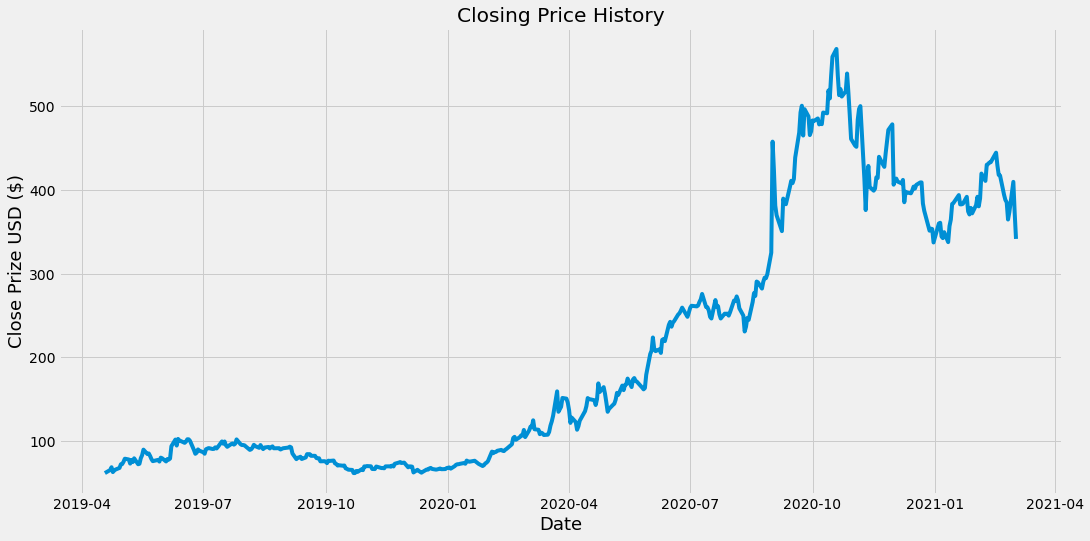

In [18]:
plt.figure(figsize =(16, 8))
plt.title('Closing Price History')
plt.plot(new_df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Prize USD ($)', fontsize=18)
plt.show()

In [19]:
# Create new df with only the 'Close' column
data = new_df.filter(['close'])

# Convert df to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

378

In [20]:
# Scale the data to apply preprocessing scaling before presenting to nueral network
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Show scaled data representing values between 0-1
scaled_data

array([[0.00000000e+00],
       [7.30734250e-03],
       [1.38247020e-02],
       [2.36994892e-03],
       [5.92487230e-03],
       [8.33432037e-03],
       [1.21854874e-02],
       [2.06778043e-02],
       [2.12505420e-02],
       [2.66619253e-02],
       [3.39297687e-02],
       [3.20733087e-02],
       [2.23762677e-02],
       [3.09673326e-02],
       [2.60891877e-02],
       [3.48184995e-02],
       [2.08160513e-02],
       [2.20010258e-02],
       [3.50752440e-02],
       [4.22640891e-02],
       [5.52593090e-02],
       [4.47722850e-02],
       [4.62930022e-02],
       [4.03483804e-02],
       [3.31002866e-02],
       [2.81431434e-02],
       [3.11450787e-02],
       [2.71951639e-02],
       [3.63787159e-02],
       [3.50159953e-02],
       [2.74519083e-02],
       [3.30607874e-02],
       [3.16783172e-02],
       [3.44235081e-02],
       [6.32973857e-02],
       [7.89982973e-02],
       [6.49168508e-02],
       [8.05190145e-02],
       [7.69245920e-02],
       [7.56211201e-02],


In [22]:
# Create the training dataset 
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]

# Split the data into x_train and y_train data sets
# x_train will be the independent training variables
# y_train will be the dependent variables
x_train = []
y_train = []

for i in range(60, len(train_data)):
  # Append past 60 values to x_train
  # contains 60 vals index from position 0 to position 59
    x_train.append(train_data[i-60:i, 0])

  #y_train will contain the 61st value 
    y_train.append(train_data[i,0])

  # Run below to visualize the x & y trains. x should be an array of 60 values and y should be 1 value being the 61st
  # Changing to if i<=61 will provide a 2nd pass through
    if i<=60:
        print(x_train)
        print(y_train)

[array([0.        , 0.00730734, 0.0138247 , 0.00236995, 0.00592487,
       0.00833432, 0.01218549, 0.0206778 , 0.02125054, 0.02666193,
       0.03392977, 0.03207331, 0.02237627, 0.03096733, 0.02608919,
       0.0348185 , 0.02081605, 0.02200103, 0.03507524, 0.04226409,
       0.05525931, 0.04477229, 0.046293  , 0.04034838, 0.03310029,
       0.02814314, 0.03114508, 0.02719516, 0.03637872, 0.035016  ,
       0.02745191, 0.03306079, 0.03167832, 0.03442351, 0.06329739,
       0.0789983 , 0.06491685, 0.08051901, 0.07692459, 0.07562112,
       0.07131571, 0.0743374 , 0.07976853, 0.07959078, 0.07597661,
       0.05413358, 0.04548327, 0.04805071, 0.05583205, 0.05290911,
       0.04909744, 0.04568077, 0.05618754, 0.05901173, 0.05679978,
       0.05713552, 0.06067069, 0.05806375, 0.06181617, 0.07465339])]
[0.06932100590183046]


In [23]:
# Convert x_train & y_train to numpy arrays  so we can use them for training the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [24]:
# Reshape the data because LSTM network expects input to be 3 dimensional and as of now our x_train is 2D
# number of sample(rows), timesteps(columns), and features(closing price)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(318, 60, 1)

In [27]:
# Build LSTM model
model = Sequential()
# add LSTM with 50 neurons 
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
318/318 [==============================] - 13s 42ms/step - loss: 0.0046


In [30]:
# Create testing dataset
# Create new array containing scaled values from index 2057 to 2646
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
# y_test contains actual 61st values (not scaled)
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [31]:
# Convert data to numpy array to use is LSTM model
x_test = np.array(x_test)

In [32]:
# Reshape the data because data is 2D and we need 3D for LSTM
# number of samples(rows), timesteps(col), features(closing price)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
# Get the models predicted price values for x_test dataset
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [34]:
# Get the root mean squared error. Closer to 0 the better
rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

40.30792752973321

C:\Users\The Dark Knight\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



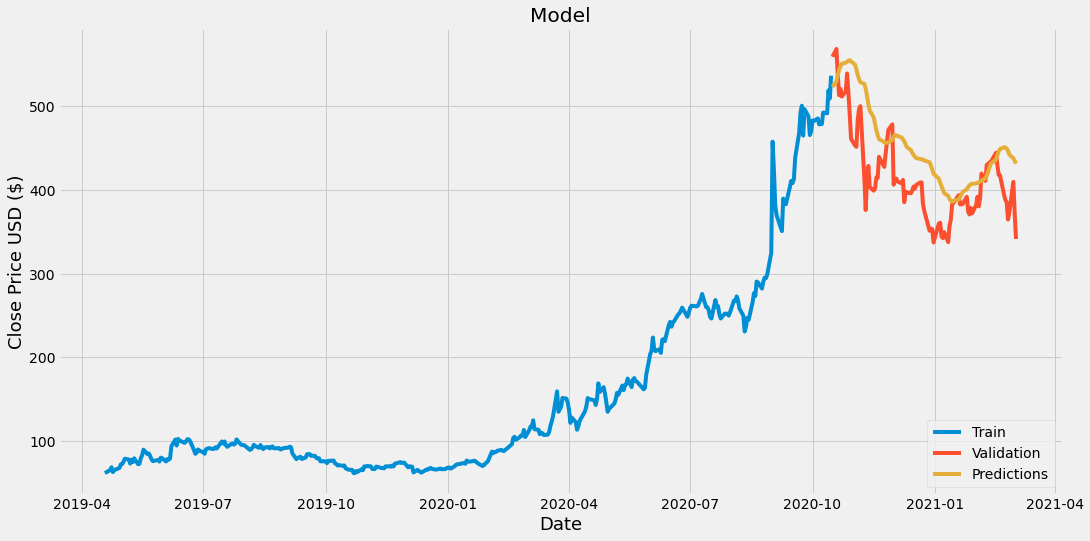

In [35]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

# Blue will indicate what the model was trained on
# Red is actual closing values
# Yellow is the prediction

In [431]:
index_valid = valid.reset_index()
index_valid_df = pd.DataFrame(index_valid)
index_valid_df.head()

,Date,close,Predictions
0,2020-10-16,559.000000,480.361206
1,2020-10-19,568.340027,486.617645
2,2020-10-20,537.020020,493.908966
3,2020-10-21,513.190002,499.611877
4,2020-10-22,520.539978,502.834290


In [433]:
stock_date = index_valid_df['Date']
stock_date_list = []

for stock in stock_date:
    collect_dates = stock
    clean_dates = datetime.strftime(collect_dates, '%Y-%m-%d')
    stock_date_list.append(clean_dates)
    
#print(stock_date_list)

In [414]:
close_data = index_valid_df['close']
close_data_list = []

for close in close_data:
    collect_close = close
    close_data_list.append(collect_close)
    
#close_data_list

In [415]:
predictions_data = index_valid_df['Predictions']
predicted_data_list = []

for predict in predictions_data:
    collect_predict = predict
    predicted_data_list.append(collect_predict)
    
#predicted_data_list

In [416]:
prediction_data = {
    'Date': stock_date_list,
    'Actual Close': close_data_list,
    'Predictions': predicted_data_list
}
#prediction_data

In [419]:
current_date = date.today().strftime('%Y-%m-%d')
print(current_date)

2021-03-03


In [418]:
db.dummy_test.update_one({'symbol': new_input}, {'$push': {'prediction': {'date': current_date, 'prediction_data': prediction_data}}})